## Annotation enrichemts
enrichments for the lead variant for each phenotype, to rule out susie funny bussiness

TODO: redo this on a grouped dataset
run these vars though vep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress
import upsetplot as up



from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [37]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

#tissue_ids = ['Adipose_Subcutaneous']
tissue_ids = tissue_ids[:11]

# load data

In [38]:
# load in the gene information 
gid_gencode, full_gencode = load_gencode()

In [47]:
pcqtls = [load_pc_cis(config, tissue_id) for tissue_id in tissue_ids]
pcqtls = pd.concat([df.assign(tissue_id=n) for df, n in zip(pcqtls, tissue_ids)]).reset_index()
pcqtls['pc_num'] = pcqtls['phenotype_id'].str.split('_pc').str[-1].astype(int)
pcqtls['cluster_size'] = pcqtls['cluster_id'].str.split('_').apply(len)
# split first, last, and middle pcs
pcqtls['pc_order'] = 'middle'
pcqtls.loc[pcqtls['pc_num'] == pcqtls['cluster_size'],'pc_order'] = 'last'
pcqtls.loc[pcqtls['pc_num'] == 1,'pc_order'] = 'first'

pcqtls['type'] = 'pcqtl'

eqtls = [load_e_cis(config, tissue_id) for tissue_id in tissue_ids]
eqtls = pd.concat([df.assign(tissue_id=n) for df, n in zip(eqtls, tissue_ids)]).reset_index()
eqtls['pc_num'] = 0
eqtls['cluster_size'] = eqtls['cluster_id'].str.split('_').apply(len)
eqtls['type'] = 'eqtl'
eqtls['pc_order'] = 'eqtl'


qtls = pd.concat([pcqtls, eqtls]).reset_index()
qtls = qtls[qtls['qval'] < .05]

# for the permutation ones which allow multiple vars per phenotype (but seemingly not overlap between phenotypes??)
#qtls['phenotype_var_id'] = qtls['phenotype_id'].astype(str) + '_' + qtls['rank'].astype(str) 

In [89]:
# group by lead variant to prevent varaints from being double counted
qtls_grouped = qtls.groupby(['variant_id', 'tissue_id', 'cluster_id']).agg({'phenotype_id':list, 
                                                                                'af':'first', 
                                                                                'qval':list, 
                                                                                'pval_perm':list, 
                                                                                'type':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list}).reset_index()
qtls_grouped['num_e_samelead'] = qtls_grouped['phenotype_id'].astype(str).str.count('_e')
qtls_grouped['num_pc_samelead'] = qtls_grouped['phenotype_id'].astype(str).str.count('_pc')
qtls_grouped['exclusive_label'] = np.where((qtls_grouped['num_e_samelead'] > 0), np.where((qtls_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

In [80]:
print('pcqtls {}'.format((qtls_grouped['num_pc_samelead'] > 0).sum()))
print('eqtls {}'.format((qtls_grouped['num_e_samelead'] > 0).sum()))

pcqtls 17139
eqtls 16314


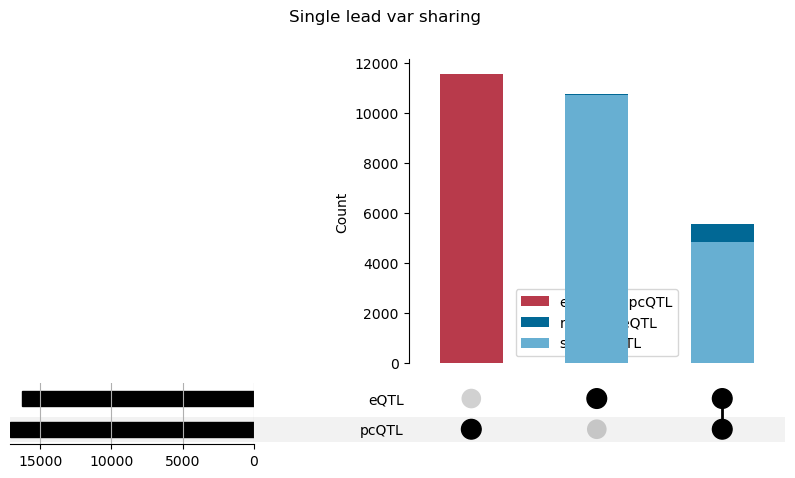

In [81]:
qtls_grouped['eQTL'] = qtls_grouped['num_e_samelead'] > 0
qtls_grouped['pcQTL'] = qtls_grouped['num_pc_samelead'] > 0
qtls_grouped['multiple_e_shared_label'] = np.where((qtls_grouped['num_e_samelead'] > 1), 'multiple eQTL', 'single eQTL')
qtls_grouped['multiple_e_shared_label'] = np.where(qtls_grouped['num_e_samelead'] > 0, qtls_grouped['multiple_e_shared_label'], 'exclusive pcQTL')

upset = qtls_grouped.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(10, 5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('Single lead var sharing')
plt.show()

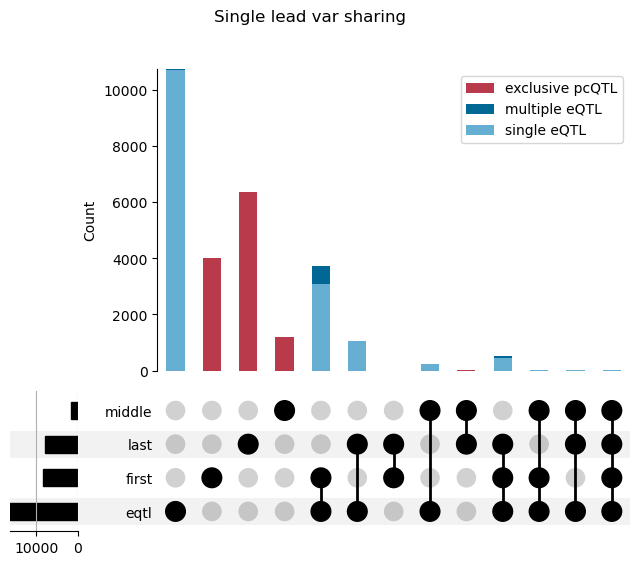

In [82]:
pc_order_upset = pd.DataFrame(up.from_memberships(qtls_grouped['pc_order']))
pc_order_upset['multiple_e_shared_label'] = qtls_grouped['multiple_e_shared_label'].values

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(pc_order_upset, subset_size="count", intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('Single lead var sharing')
plt.show()

In [90]:
def load_avg_exression(avg_expression_path = f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv'):
    tissue_avg_expression = pd.read_csv(avg_expression_path, sep='\t', index_col=0)
    return tissue_avg_expression

def annotate_avg_expression(qtls, tissue_avg_expression):
    for idx, row in tqdm(qtls.iterrows(), total=len(qtls)):
        transcript_list = row['cluster_id'].split('_')
        cluster_avg_expression = tissue_avg_expression.loc[row['tissue_id'],transcript_list]
        qtls.loc[idx, 'avg_expression'] = np.mean(cluster_avg_expression)
        qtls.loc[idx, 'avg_log_expression'] = np.mean(np.log10(cluster_avg_expression))
        qtls.loc[idx, 'median_expression'] = np.median(cluster_avg_expression)
        qtls.loc[idx, 'min_expression'] = np.min(cluster_avg_expression)



annotate_avg_expression(qtls_grouped, load_avg_exression())

 ... (more hidden) ...

In [ ]:
ax=sns.histplot(data=qtls_grouped, hue='exclusive_label', x='median_expression', stat='percent', common_norm=False, bins=100, log_scale=True)


ValueError: Could not interpret value `exclusive_label` for `hue`. An entry with this name does not appear in `data`.

### old version 
no grouping

In [5]:
# create overlap columns
def shared_lead_var(row, qtl_df):
    matched_cluster_df = qtl_df[qtl_df['cluster_id']==row.cluster_id]
    shared_qtls = matched_cluster_df[matched_cluster_df['variant_id'] == row['variant_id']]
    #shared_qtls = shared_qtls[~(shared_qtls['phenotype_var_id']==row['phenotype_var_id'])]
    return str(shared_qtls['phenotype_id'].to_list())
    
qtls['e_samelead'] = qtls.progress_apply(shared_lead_var, axis=1, args=(qtls[qtls['type']=='eqtl'],))
qtls['pc_samelead'] = qtls.progress_apply(shared_lead_var, axis=1, args=(qtls[qtls['type']=='pcqtl'],))
qtls['num_e_samelead'] = qtls['e_samelead'].apply(ast.literal_eval).apply(len)
qtls['num_pc_samelead'] = qtls['pc_samelead'].apply(ast.literal_eval).apply(len)
   

 ... (more hidden) ...
 ... (more hidden) ...


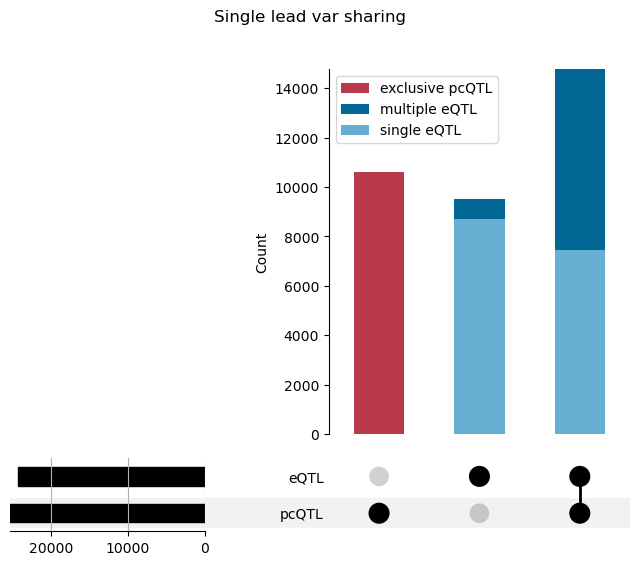

In [6]:
qtls['eQTL'] = qtls['num_e_samelead'] > 0
qtls['pcQTL'] = qtls['num_pc_samelead'] > 0
qtls['multiple_e_shared_label'] = np.where((qtls['num_e_samelead'] > 1), 'multiple eQTL', 'single eQTL')
qtls['multiple_e_shared_label'] = np.where(qtls['num_e_samelead'] > 0, qtls['multiple_e_shared_label'], 'exclusive pcQTL')

upset = qtls.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('Single lead var sharing')
plt.show()

In [7]:
qtls['exclusive_label'] = np.where((qtls['num_e_samelead'] > 0), np.where((qtls['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')
qtls['pc_num'] = np.where(qtls['type']=='pcqtl',  qtls['phenotype_id'].str.split('_pc').str[-1], 0)
qtls['pc_num'] = qtls['pc_num'].astype(int)
# add in cluster size
qtls['cluster_size'] = qtls['cluster_id'].str.split('_').apply(len)
# split first, last, and middle pcs
qtls['pc_order'] = 'middle'
qtls.loc[qtls['pc_num'] == qtls['cluster_size'],'pc_order'] = 'last'
qtls.loc[qtls['pc_num'] == 1,'pc_order'] = 'first'
qtls.loc[qtls['type'] == 'eqtl','pc_order'] = 'eqtl'

<AxesSubplot: xlabel='pc_order', ylabel='Percent'>

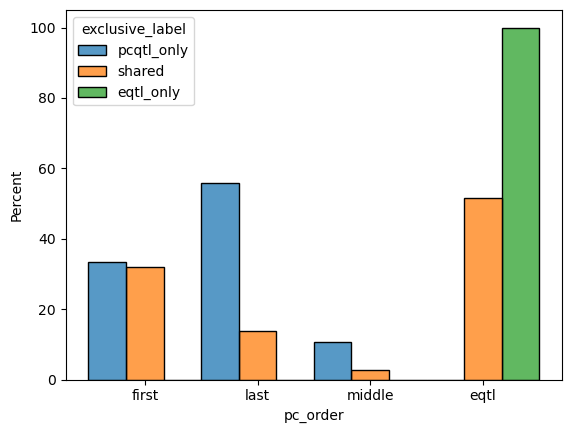

In [8]:
sns.histplot(qtls, hue='exclusive_label', x='pc_order', common_norm=False, multiple='dodge', stat='percent')

# some other annotaiton categories
from data used in cluster annotations

* ABC enhancer
* CTCF site
* near tad boundry


pc eigenvalue

In [9]:
# pc_dfs = []
# for tissue_id in load_tissue_ids(config):    
#     pc_df = load_pc(config, tissue_id)
#     expression_df = load_cluster_expression(config, tissue_id)  
#     sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]
#     for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
#         expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
#         gene_variances = []
#         for i in range(len(expression_cluster)):
#             # pull the right data
#             pc_values = row[sample_ids].astype('float')
#             expression_values = expression_cluster.loc[i, sample_ids].astype('float')
#             # get the r squared value
#             slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
#             gene_variances.append((r_value**2)*100)
#         gene_variances.sort()
#         pc_df.loc[idx, 'largest_variance'] = gene_variances[-1]
#         pc_df.loc[idx, 'second_largest_variance'] = gene_variances[-2]
#         pc_df.loc[idx, 'total_variance'] = sum(gene_variances)
#         pc_df.loc[idx, 'variance_list'] = str(gene_variances)
#     pc_df['tissue_id'] = tissue_id
#     pc_dfs.append(pc_df)

# #write out
# pc_df = pd.concat(pc_dfs)
# pc_df = pc_df.copy()
# pc_df['chr'] = pc_df['#chr']
# pc_df = pc_df[['chr', 'start', 'end', 'gene_id', 'largest_variance', 'second_largest_variance', 'total_variance', 'variance_list']]
# pc_df.to_csv('{}/{}/pc_annotated.csv'.format(prefix, config['pc_output_dir']), index=None)

In [10]:
#load in 
pc_df = pd.read_csv('{}/{}/pc_annotated.csv'.format(prefix, config['pc_output_dir']))

In [11]:
pcqtls = qtls[qtls['type']=='pcqtl']
pcqtls = pd.merge(pcqtls, pc_df, left_on='phenotype_id', right_on = 'gene_id')

In [12]:
pc_df['has_pcqtl'] = pc_df['gene_id'].isin(qtls['phenotype_id'].unique())
pc_df['has_unique_pcqtl'] = pc_df['gene_id'].isin(qtls[qtls['num_e_samelead']==0]['phenotype_id'].unique())
pc_df['qtl_label'] = np.where(pc_df['has_pcqtl'], np.where(pc_df['has_unique_pcqtl'], 'unique pcqtl', 'shared pcqtl'), 'no pcqtl')

In [13]:
pc_df['pc_num'] = pc_df['gene_id'].str.split('_pc').str[-1].astype(int)
pc_df['cluster_size'] = pc_df['gene_id'].str.split('_').apply(len) - 1
pc_df['pc_order'] = 'middle'
pc_df.loc[pc_df['pc_num'] == pc_df['cluster_size'],'pc_order'] = 'last'
pc_df.loc[pc_df['pc_num'] == 1,'pc_order'] = 'first'

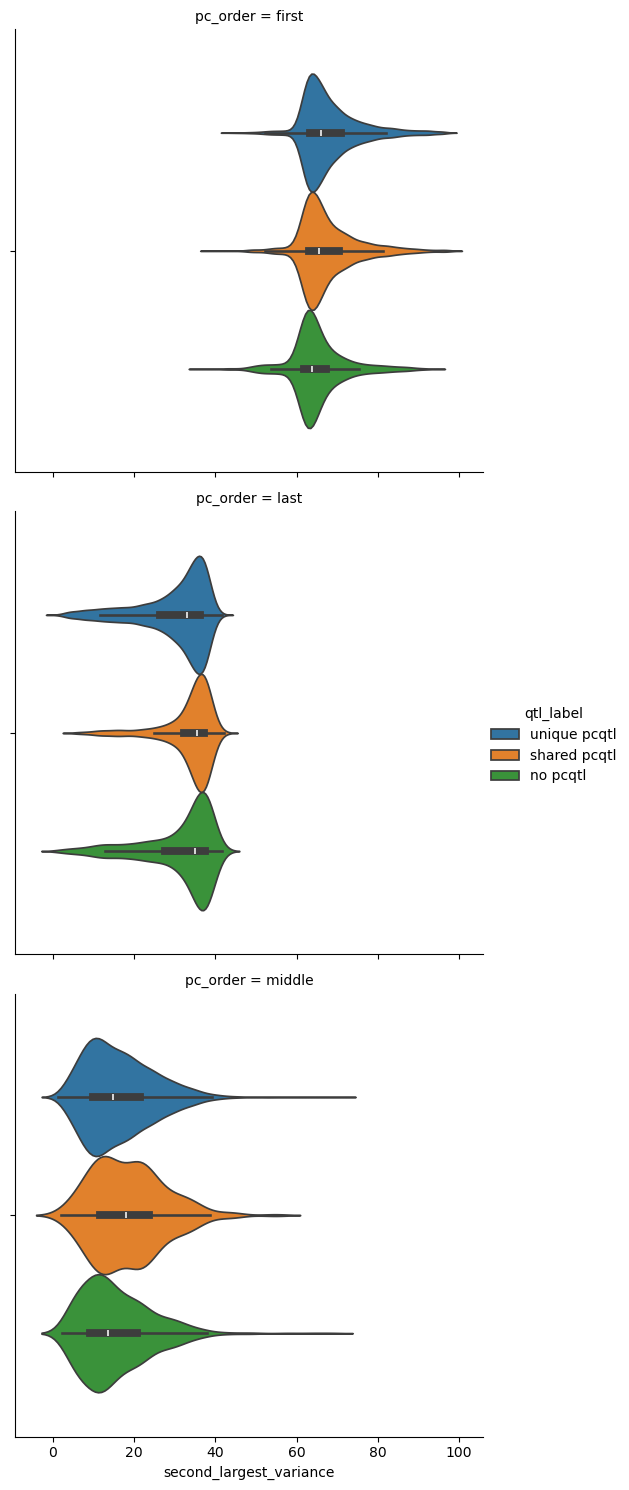

In [14]:
sns.catplot(pc_df, kind='violin', x='second_largest_variance', row='pc_order', hue='qtl_label')

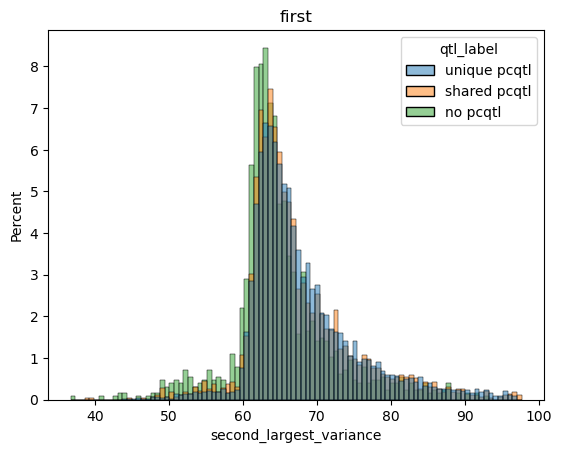

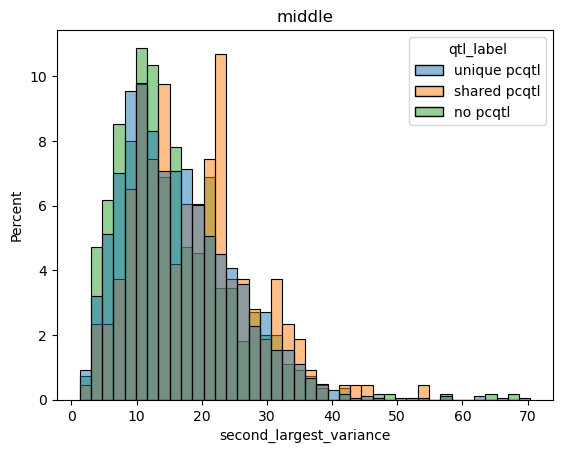

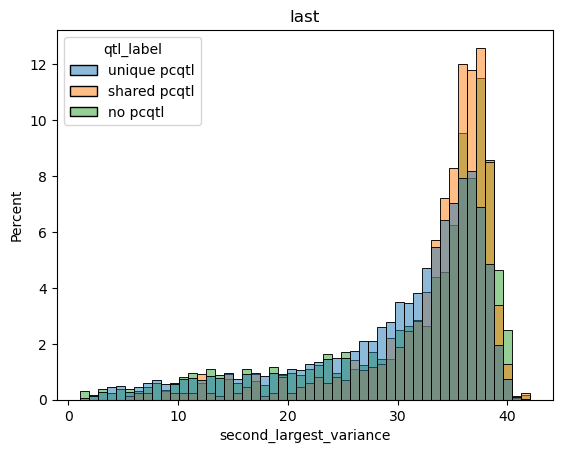

In [15]:
# are pcs that explain more varience more likely to have a pcqtl? 
for order in ['first', 'middle', 'last']:
    ax = sns.histplot(data=pc_df[pc_df['pc_order']==order], hue='qtl_label', 
                      x='second_largest_variance', common_norm=False, stat='percent', 
                      hue_order=['unique pcqtl', 'shared pcqtl', 'no pcqtl'])
    ax.set_title(order)

    plt.show()

<AxesSubplot: xlabel='largest_variance', ylabel='cluster_size'>

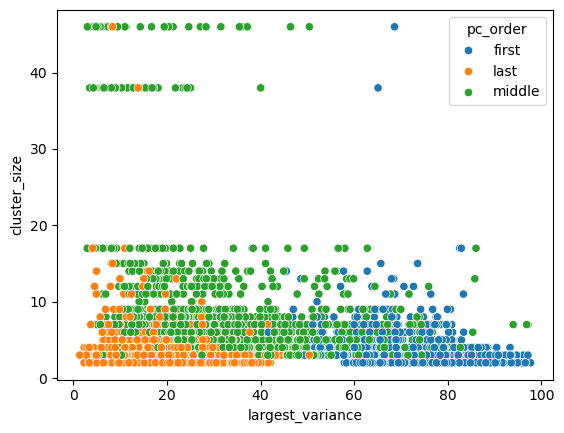

In [16]:
sns.scatterplot(pc_df, x='largest_variance', y='cluster_size', hue='pc_order')

expression level

In [17]:
def load_avg_exression(avg_expression_path = f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv'):
    tissue_avg_expression = pd.read_csv(avg_expression_path, sep='\t', index_col=0)
    return tissue_avg_expression

def annotate_avg_expression(vep_df, tissue_avg_expression):
    for idx, row in tqdm(vep_df.iterrows(), total=len(vep_df)):
        transcript_list = row['cluster_id'].split('_')
        cluster_avg_expression = tissue_avg_expression.loc[row['tissue_id'],transcript_list]
        vep_df.loc[idx, 'avg_expression'] = np.mean(cluster_avg_expression)
        vep_df.loc[idx, 'avg_log_expression'] = np.mean(np.log10(cluster_avg_expression))
        vep_df.loc[idx, 'median_expression'] = np.median(cluster_avg_expression)
        vep_df.loc[idx, 'min_expression'] = np.min(cluster_avg_expression)



annotate_avg_expression(qtls, load_avg_exression())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34901/34901 [01:16<00:00, 457.04it/s]


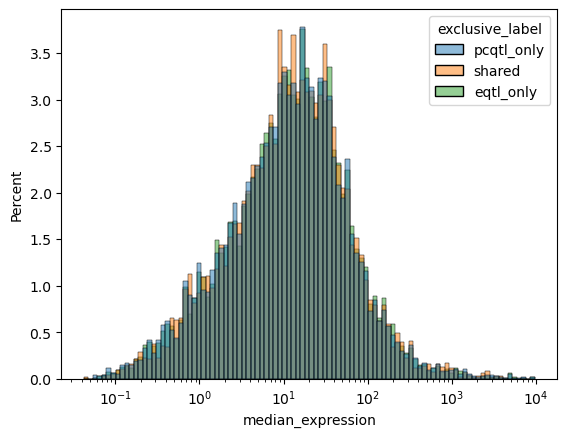

In [18]:
ax=sns.histplot(data=qtls, hue='exclusive_label', x='median_expression', stat='percent', common_norm=False, bins=100, log_scale=True)
#ax.set_yscale('log')

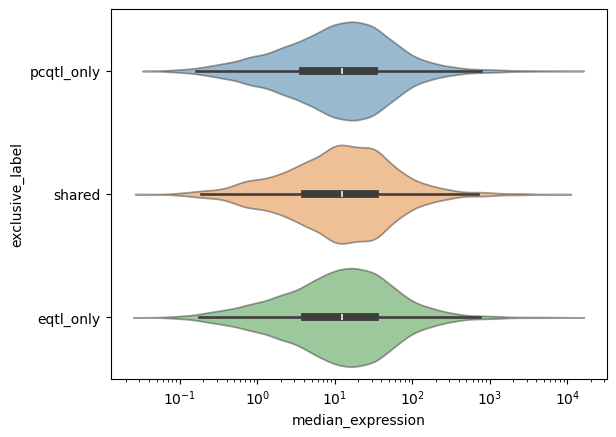

In [19]:
ax=sns.violinplot(data=qtls, hue='exclusive_label', x='median_expression', y='exclusive_label', log_scale=True, alpha=.5)


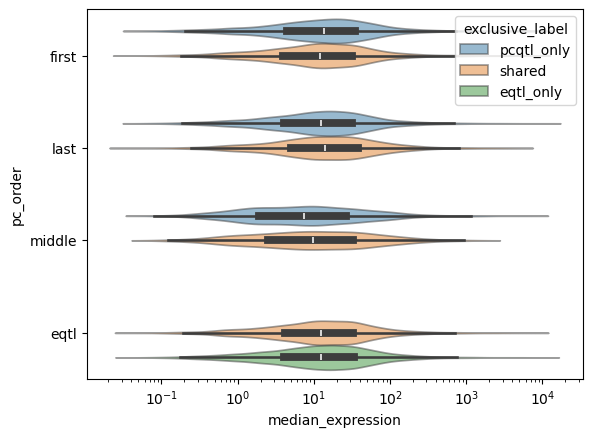

In [20]:
ax=sns.violinplot(data=qtls, hue='exclusive_label', x='median_expression', y='pc_order', log_scale=True, alpha=.5)


effect size

In [21]:
qtls['abs_slope'] = qtls['slope'].abs()

<AxesSubplot: xlabel='abs_slope', ylabel='Count'>

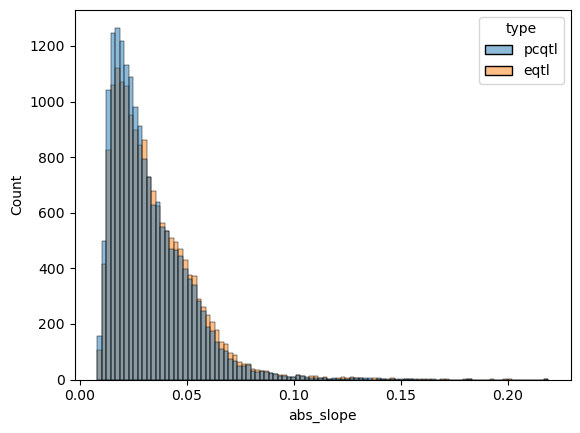

In [22]:
sns.histplot(qtls, x='abs_slope', hue='type', common_norm=False, bins=100)

In [23]:
# effect size is in pc units, needs to be converted into e gene units
def add_variance(nominal_df):
    nominal_df['variance'] = nominal_df['slope'].apply(np.square) * 100

var_annot_qtls = []
for my_tissue_id in tqdm(qtls['tissue_id'].unique()):

    sub_qtls = qtls[qtls['tissue_id'] == my_tissue_id]
    e_nominal = load_e_nominal_all_chr(config, my_tissue_id)
    pc_nominal = load_pc_nominal_all_chr(config, my_tissue_id)

    vid_pc_nominal = pc_nominal.set_index('variant_id')
    vid_pc_nominal = vid_pc_nominal.loc[sub_qtls['variant_id']]

    vid_e_nominal = e_nominal.set_index('variant_id')
    vid_e_nominal = vid_e_nominal.loc[sub_qtls['variant_id']]
    add_variance(vid_e_nominal)

    vid_e_nominal_grouped = vid_e_nominal.groupby('variant_id').agg({'variance':max}).reset_index()

    vid_pc_nominal_mereged = pd.merge(vid_pc_nominal.reset_index(), vid_e_nominal_grouped, 
            suffixes=['_pc', '_e'], how='left', left_on='variant_id', right_on='variant_id')

    sub_qtls_pc = pd.merge(sub_qtls, vid_pc_nominal_mereged[['variant_id', 'phenotype_id', 'variance']], 
            left_on=['variant_id', 'phenotype_id'], right_on=['variant_id', 'phenotype_id'], how='left')

    sub_qtls_pc = pd.merge(sub_qtls_pc, vid_e_nominal.reset_index()[['variant_id', 'phenotype_id', 'variance']], 
            left_on=['variant_id', 'phenotype_id'], right_on=['variant_id', 'phenotype_id'], how='left')

    sub_qtls_pc['variance'] = np.where(sub_qtls_pc['variance_x'].isna(), sub_qtls_pc['variance_y'], sub_qtls_pc['variance_x'])
    sub_qtls_pc['tissue_id'] = my_tissue_id
    var_annot_qtls.append(sub_qtls_pc)

var_annot_qtls = pd.concat(var_annot_qtls).drop_duplicates()    

  0%|                                                                                                                                                                                                                           | 0/11 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [23:33<00:00, 128.51s/it]


In [62]:
var_annot_qtls[['phenotype_id', 'tissue_id', 'variant_id', 'variance']].to_csv('{}/{}/var_annotated_qtls.csv'.format(prefix, config['annotations_output_dir']))

In [24]:
qtls = pd.merge(qtls, var_annot_qtls[['phenotype_id', 'tissue_id', 'variant_id', 'variance']], left_on=['phenotype_id', 'tissue_id', 'variant_id'], 
         right_on=['phenotype_id', 'tissue_id', 'variant_id'], how='left')

<AxesSubplot: xlabel='variance', ylabel='Percent'>

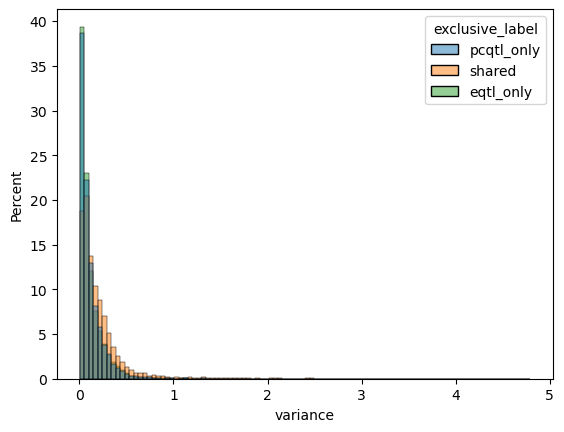

In [25]:
sns.histplot(qtls, x='variance', hue='exclusive_label', common_norm=False, bins=100, stat='percent')

<AxesSubplot: xlabel='variance'>

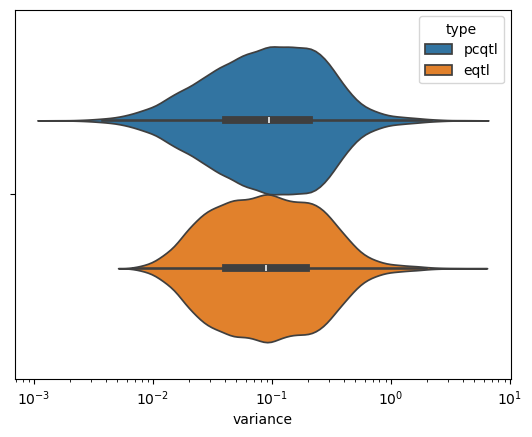

In [75]:
sns.violinplot(qtls, x='variance', hue='type', log_scale=True)

abc

In [26]:
full_abc_path= '/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz'
abc_match_path='/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/ABC_matched_gtex.csv'   
full_abc_pred_df = pd.read_csv(full_abc_path, sep='\t')
abc_gtex_match = pd.read_csv(abc_match_path)

full_abc_pred_df = full_abc_pred_df[full_abc_pred_df['CellType'].isin(abc_gtex_match['ABC_biosample_id'])]
gene_enhancer_df = pd.merge(full_gencode[['transcript_id', 'gene_name']], full_abc_pred_df[['chr', 'start', 'end', 'TargetGene','name','class', 'ABC.Score', 'CellType']], left_on='gene_name', right_on='TargetGene', how='left')
gene_enhancer_df.rename(columns={'name':'enhancer'}, inplace=True)
gene_enhancer_df.set_index('transcript_id', inplace=True)
gene_enhancer_df.dropna(inplace=True)

gene_enhancer_df['chr'] = gene_enhancer_df['chr'].str.split('chr').str[1]
gene_enhancer_df = gene_enhancer_df[gene_enhancer_df['chr'].isin(f'{i+1}' for i in range(22))]
gene_enhancer_df['chr'] = gene_enhancer_df['chr'].astype(int)
gene_enhancer_df['enhancer_start'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[0].astype(int)
gene_enhancer_df['enhancer_end'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[1].astype(int)

<AxesSubplot: xlabel='enhancer_size', ylabel='Count'>

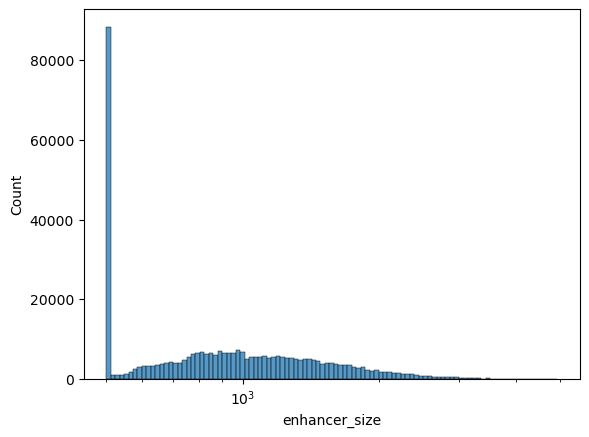

In [27]:
gene_enhancer_df['enhancer_size'] = gene_enhancer_df['enhancer_end'] - gene_enhancer_df['enhancer_start']
sns.histplot(gene_enhancer_df['enhancer_size'], log_scale=True)

In [28]:
qtls['chr'] = qtls['variant_id'].str.split('_').str[0].str.strip('chr').astype(int)
qtls['position'] = qtls['variant_id'].str.split('_').str[1].astype(int)

In [29]:
for tissue_id, sub_qtl in qtls.groupby('tissue_id'):
    tissue_enhancers = gene_enhancer_df[gene_enhancer_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == tissue_id]['ABC_biosample_id'].iloc[0]]
    print(tissue_id)
    print(len(tissue_enhancers))
    for idx, qtl_row in tqdm(sub_qtl.iterrows(), total=len(sub_qtl)):
        matched_enhancers = tissue_enhancers[(tissue_enhancers['chr'] == qtl_row['chr'])&(tissue_enhancers['enhancer_start'] <= qtl_row['position'])&(tissue_enhancers['enhancer_end'] >= qtl_row['position'])]
        all_enhancers = gene_enhancer_df[(gene_enhancer_df['chr'] == qtl_row['chr'])&(gene_enhancer_df['enhancer_start'] <= qtl_row['position'])&(gene_enhancer_df['enhancer_end'] >= qtl_row['position'])]

        # is qtl in any abc enhancer?
        qtls.loc[idx, 'qtl_num_abc_enhancers'] = matched_enhancers['enhancer'].nunique()
        qtls.loc[idx, 'qtl_num_abc_all_enhancers'] = all_enhancers['enhancer'].nunique()
        # how many genes does the enhancer contact?
        qtls.loc[idx, 'qtl_num_abc_genes'] = matched_enhancers['TargetGene'].nunique()
        qtls.loc[idx, 'qtl_num_abc_all_genes'] = all_enhancers['TargetGene'].nunique()
        # how many cluster genes?
        qtls.loc[idx, 'qtl_matched_abc_genes'] = pd.Series(matched_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()
        qtls.loc[idx, 'qtl_matched_abc_all_genes'] = pd.Series(all_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()


Adipose_Subcutaneous
47836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3352/3352 [00:21<00:00, 156.63it/s]


Adipose_Visceral_Omentum
0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2424/2424 [00:15<00:00, 160.12it/s]


Artery_Tibial
46844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3340/3340 [00:21<00:00, 155.94it/s]


Cells_Cultured_fibroblasts
47242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3516/3516 [00:22<00:00, 153.37it/s]


Esophagus_Mucosa
0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3163/3163 [00:19<00:00, 161.64it/s]


Esophagus_Muscularis
0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2464/2464 [00:15<00:00, 159.76it/s]


Lung
43697


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2931/2931 [00:19<00:00, 152.30it/s]


Muscle_Skeletal
47659


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3783/3783 [00:28<00:00, 134.17it/s]


Nerve_Tibial
0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3306/3306 [00:22<00:00, 144.30it/s]


Skin_Not_Sun_Exposed_Suprapubic
47964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2838/2838 [00:18<00:00, 156.38it/s]


Skin_Sun_Exposed_Lower_leg
44610


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3784/3784 [00:24<00:00, 156.08it/s]


In [30]:
print('total qtls: {}'.format(len(qtls)))
print('qtls with enhancers in matched tissue: {}'.format((qtls['qtl_num_abc_enhancers'] > 0).sum()))
print('qtls with enhancers in any tissue: {}'.format((qtls['qtl_num_abc_all_enhancers'] > 0).sum()))

print('qtls with cluster regulating enhancers in matched tissue: {}'.format((qtls['qtl_matched_abc_genes'] > 0).sum()))
print('qtls with cluster regulating enhancers in any tissue: {}'.format((qtls['qtl_matched_abc_all_genes'] > 0).sum()))


total qtls: 34901
qtls with enhancers in matched tissue: 393
qtls with enhancers in any tissue: 1675
qtls with cluster regulating enhancers in matched tissue: 149
qtls with cluster regulating enhancers in any tissue: 637


Text(0.5, 1.0, 'Matched tissue Enhancer overlap')

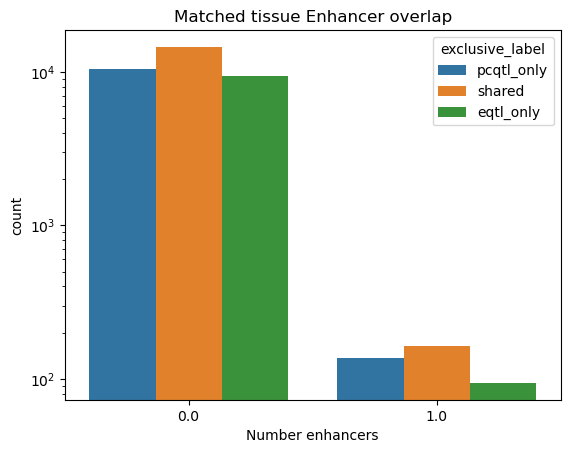

In [31]:
ax = sns.countplot(data=qtls, hue='exclusive_label', x='qtl_num_abc_enhancers')
ax.set_yscale('log')
plt.xlabel('Number enhancers')
plt.title('Matched tissue Enhancer overlap')

Text(0.5, 1.0, 'Matched tissue E-P connections ')

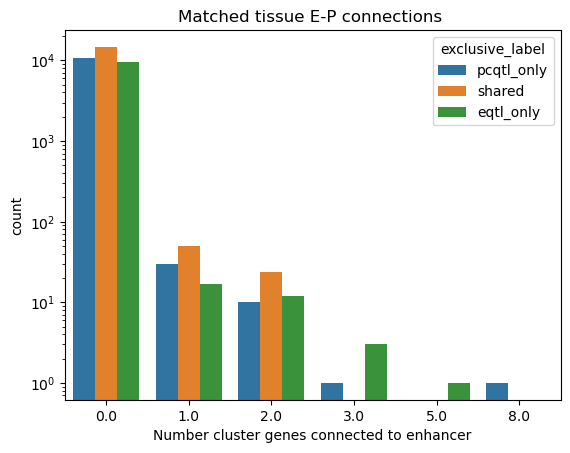

In [32]:
ax = sns.countplot(data=qtls, hue='exclusive_label', x='qtl_matched_abc_genes')
ax.set_yscale('log')

plt.xlabel('Number cluster genes connected to enhancer')
plt.title('Matched tissue E-P connections ')

Text(0.5, 1.0, 'Any tissue E-P connections')

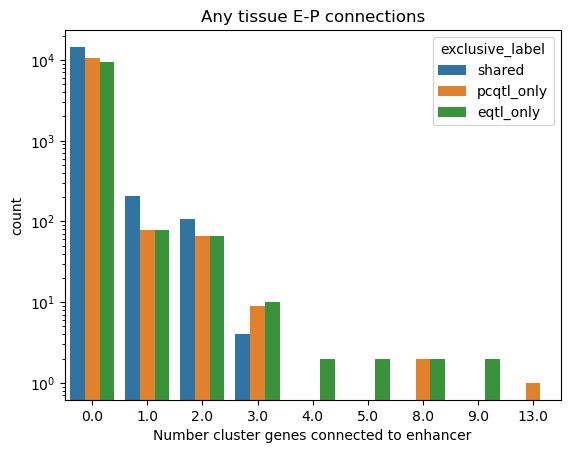

In [33]:
ax = sns.countplot(data=qtls, hue='exclusive_label', x='qtl_matched_abc_all_genes')
ax.set_yscale('log')

plt.xlabel('Number cluster genes connected to enhancer')
plt.title('Any tissue E-P connections')

(0.0, 10.0)

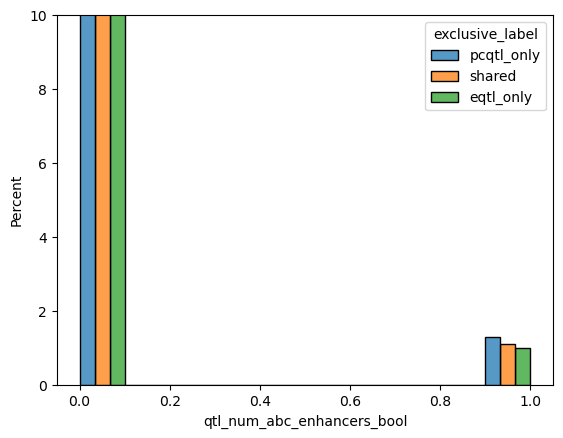

In [139]:
qtls['qtl_num_abc_enhancers_bool'] = qtls['qtl_num_abc_enhancers'] > 0

ax=sns.histplot(data=qtls, hue='exclusive_label', x='qtl_num_abc_enhancers_bool', stat='percent', common_norm=False, bins=10, multiple='dodge')
ax.set_ylim(0, 10)

(0.0, 10.0)

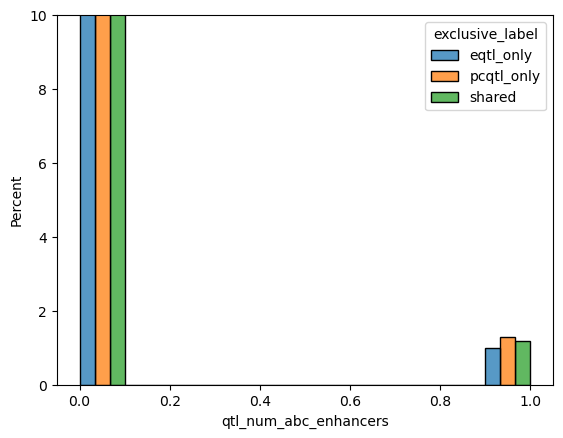

In [138]:
qtls_grouped = qtls.groupby(['variant_id', 'tissue_id', 'cluster_id']).agg({'phenotype_id':list, 'qtl_num_abc_enhancers':'sum', 'exclusive_label':'first'})
qtls_grouped['qtl_num_abc_enhancers'] = qtls_grouped['qtl_num_abc_enhancers'] > 0
ax=sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qtl_num_abc_enhancers', stat='percent', common_norm=False, bins=10, multiple='dodge')
ax.set_ylim(0, 10)

ctcf

In [35]:

qtls['tss_min'] = qtls['position']
qtls['tss_max'] = qtls['position']
qtls['Chromosome'] = qtls['chr']

annotated = []
for tissue_id, sub_qtl in qtls.groupby('tissue_id'):
    ctcf_df = load_ctcf(tissue_id)
    annotate_ctcf(sub_qtl, ctcf_df)
    annotated.append(sub_qtl)

qtls_ctcf =  pd.concat(annotated)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3784/3784 [00:04<00:00, 814.73it/s]


In [36]:
qtls['qtl_in_ctcf'] = qtls_ctcf['has_ctcf_peak']

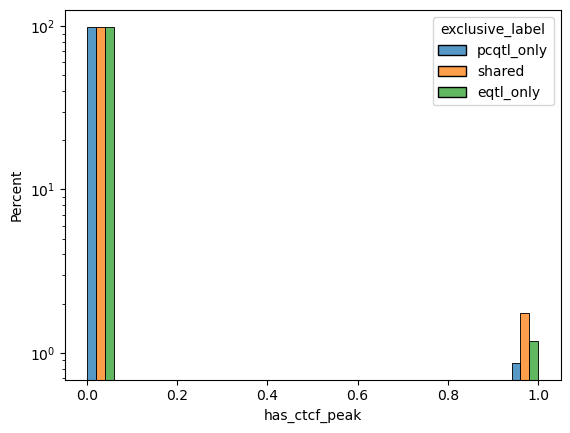

In [37]:
ax = sns.histplot(data=qtls_ctcf, hue='exclusive_label', x='has_ctcf_peak', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')

in a tad?

In [208]:
tad_df = load_tad()
qtls['qtl_inter'] = pd.arrays.IntervalArray.from_arrays(qtls['position'], qtls['position']+5000)
qtls['num_tads_qtl'] = qtls.progress_apply(count_tad_overlap, axis=1, args=(tad_df, 'qtl_inter'))
qtls['qtl_in_tad'] = qtls['num_tads_qtl'] > 1

  0%|                                                                                                                                                                                                                                                                                  | 0/34901 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34901/34901 [01:13<00:00, 473.00it/s]


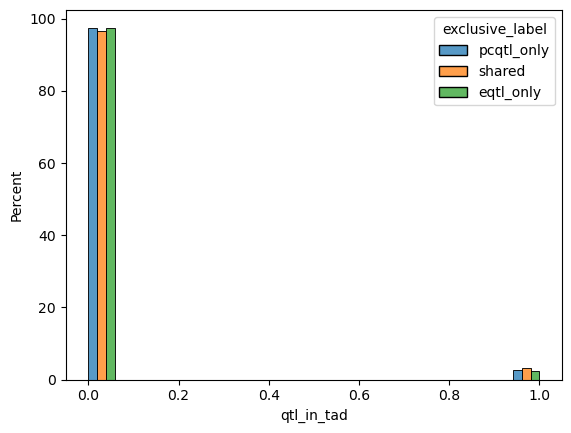

In [209]:
ax = sns.histplot(data=qtls, hue='exclusive_label', x='qtl_in_tad', common_norm=False, stat='percent', multiple='dodge')

cluster information

In [210]:
clusters = load_across_tissues(config, load_clusters_annotated)
qtls_cluster_annotated = pd.merge(qtls, clusters, left_on=['cluster_id', 'tissue_id'], right_on=['cluster_id', 'Tissue'], suffixes=['_qtl', '_cluster'])

<AxesSubplot: xlabel='has_high_pos_corr', ylabel='Percent'>

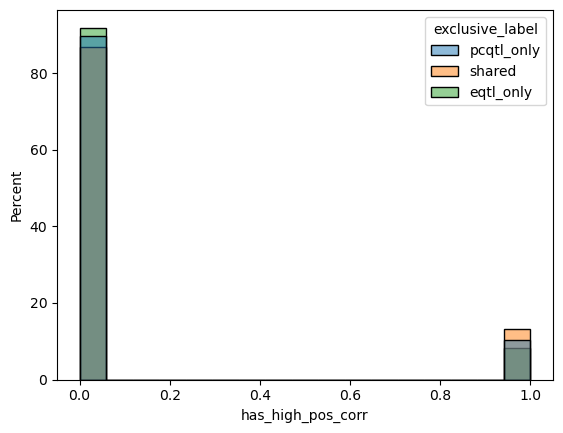

In [211]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_high_pos_corr', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Percent'>

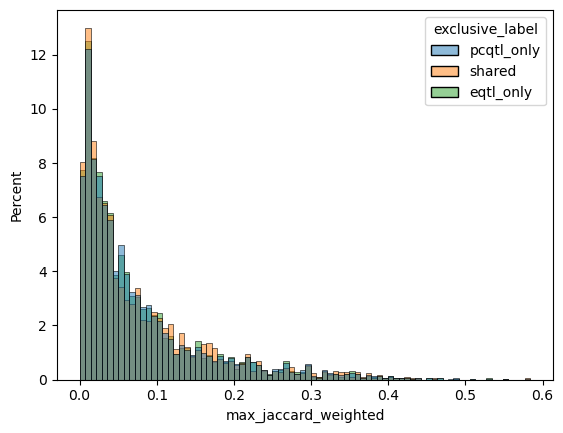

In [212]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_weighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Percent'>

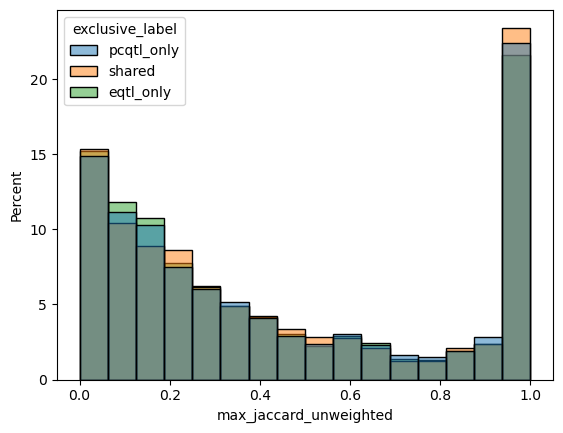

In [213]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_unweighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_shared_go_all', ylabel='Percent'>

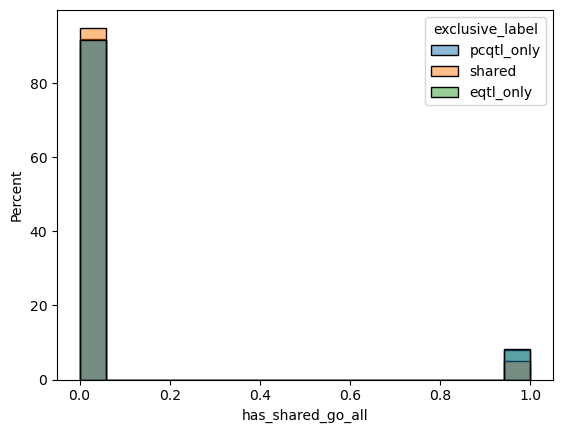

In [214]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_shared_go_all', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_cross_map', ylabel='Percent'>

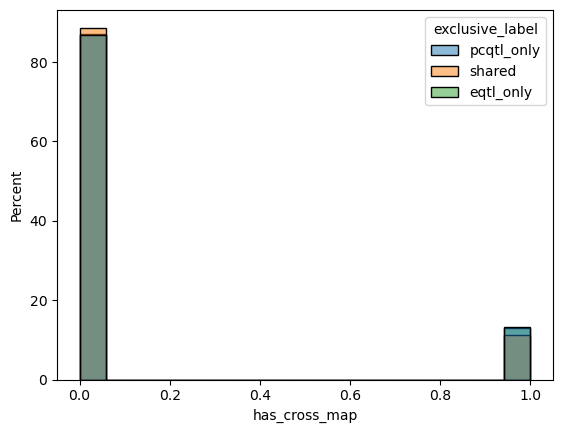

In [215]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_cross_map', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_paralog', ylabel='Percent'>

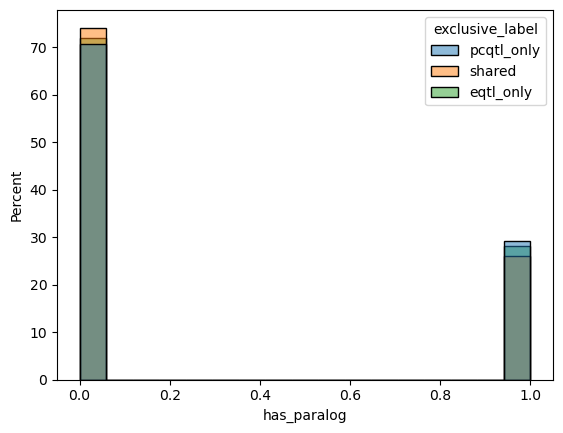

In [216]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_paralog', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_shared_strong_enhancers', ylabel='Percent'>

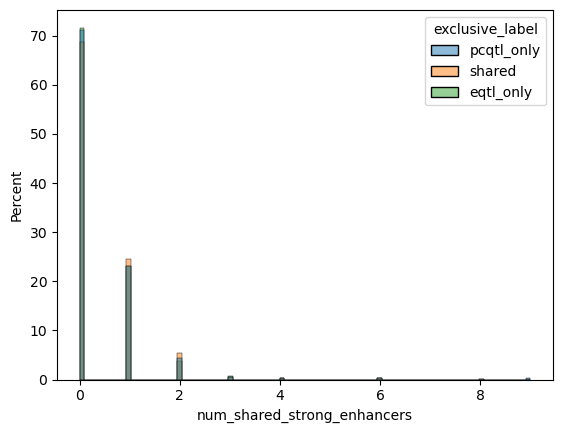

In [217]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='num_shared_strong_enhancers', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Percent'>

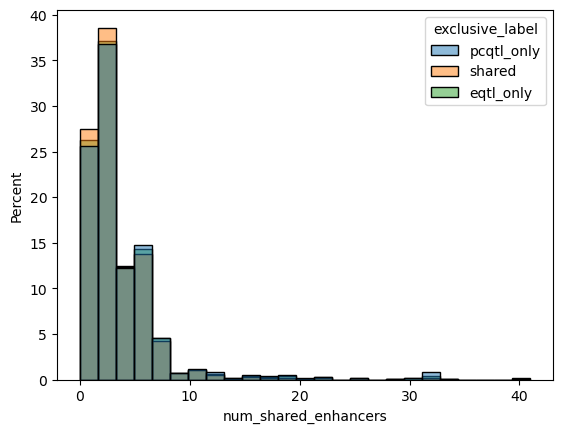

In [218]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='num_shared_enhancers', stat='percent', common_norm=False, bins=25)

<AxesSubplot: xlabel='num_tads_tss', ylabel='Percent'>

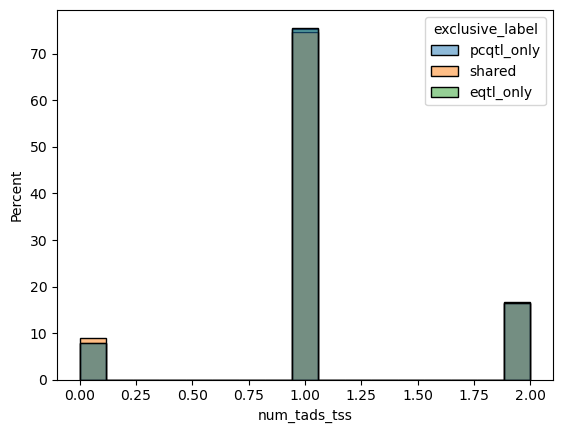

In [219]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='num_tads_tss', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_bidirectional_promoter', ylabel='Percent'>

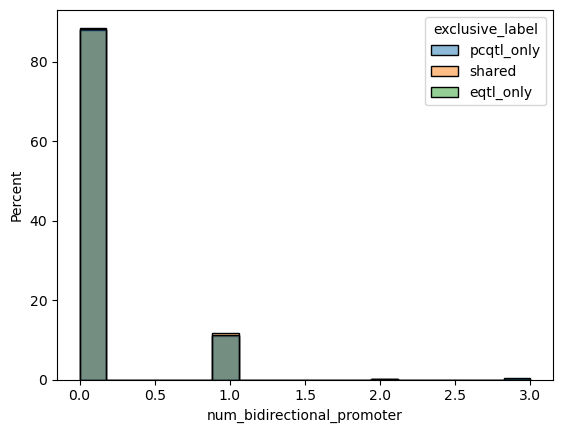

In [220]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='num_bidirectional_promoter', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_abc_genes', ylabel='Percent'>

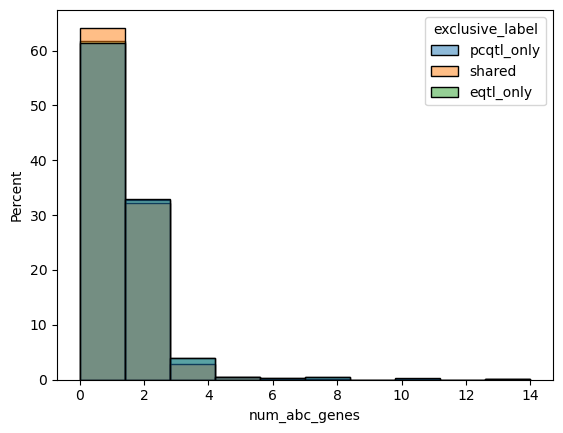

In [221]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='num_abc_genes', stat='percent', common_norm=False, bins=10)

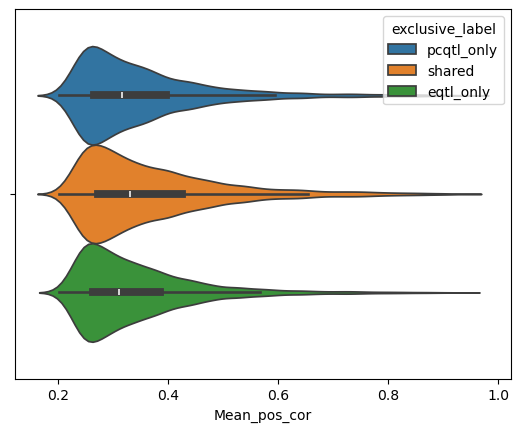

In [222]:
ax=sns.violinplot(data=qtls_cluster_annotated, hue='exclusive_label', x='Mean_pos_cor')


qtl in bidirecitonal promoter

In [223]:
# in a bidirectional promoter?
qtls_cluster_annotated['in_bidirectional_promoter'] = False
qtls_cluster_annotated['in_shared_promoter'] = False
sub_qtls = qtls_cluster_annotated[qtls_cluster_annotated['has_bidirectional_promoter']]
for qtl_idx, row in tqdm(sub_qtls.iterrows(), total=len(sub_qtls)):
    transcript_ids = row['cluster_id'].split('_')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    # in the promoter if within 1kb of tss_start
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                if ((row['position'] - first_gene_row['tss_start']) < 1000) & ((row['position'] - second_gene_row['tss_start']) < 1000):
                    qtls_cluster_annotated.loc[qtl_idx, 'in_bidirectional_promoter'] = True
            elif close:
                # found a shared promotor
                if ((row['position'] - first_gene_row['tss_start']) < 1000) & ((row['position'] - second_gene_row['tss_start']) < 1000):
                    qtls_cluster_annotated.loc[qtl_idx, 'in_shared_promoter'] = True


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4068/4068 [00:10<00:00, 400.45it/s]


<AxesSubplot: xlabel='in_bidirectional_promoter', ylabel='Percent'>

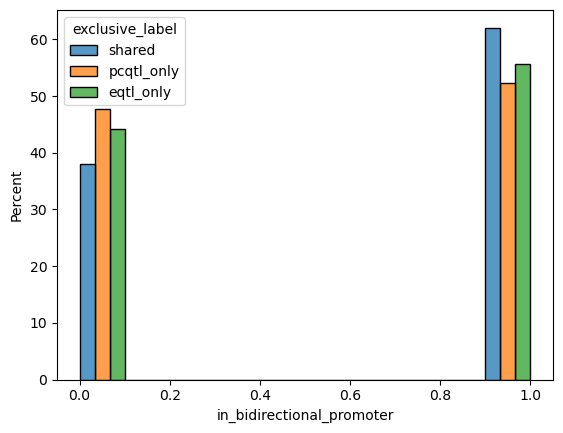

In [224]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['has_bidirectional_promoter']], hue='exclusive_label', x='in_bidirectional_promoter', stat='percent', common_norm=False, bins=10, multiple='dodge')

<AxesSubplot: xlabel='in_bidirectional_promoter', ylabel='Percent'>

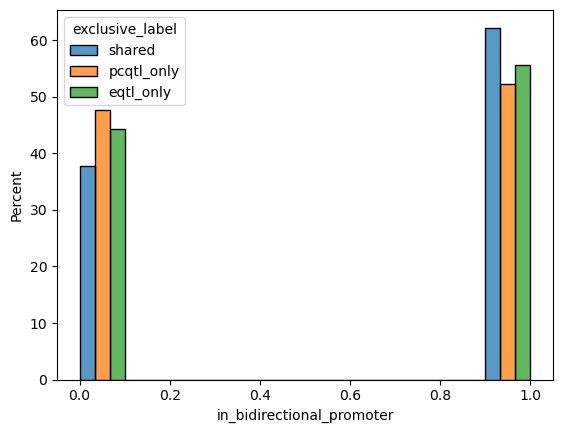

In [225]:
qtls_grouped = qtls_cluster_annotated.groupby(['variant_id', 'tissue_id_cluster', 'cluster_id']).agg({'phenotype_id':list, 'in_bidirectional_promoter':'sum', 'has_bidirectional_promoter':'sum', 'exclusive_label':'first'})
qtls_grouped['in_bidirectional_promoter'] = qtls_grouped['in_bidirectional_promoter'] > 0
sns.histplot(data=qtls_grouped[qtls_grouped['has_bidirectional_promoter']>0], hue='exclusive_label', x='in_bidirectional_promoter', stat='percent', common_norm=False, bins=10, multiple='dodge')

<AxesSubplot: xlabel='between_tss', ylabel='Percent'>

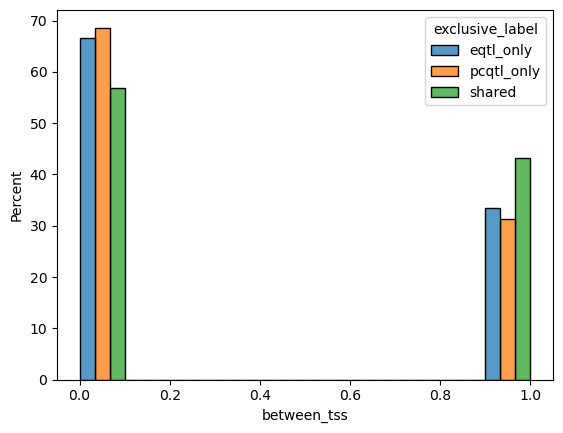

In [226]:
qtls_cluster_annotated['between_tss'] = ((qtls_cluster_annotated['tss_min_cluster'] < qtls_cluster_annotated['position']) & (qtls_cluster_annotated['tss_max_cluster'] > qtls_cluster_annotated['position']))
qtls_grouped = qtls_cluster_annotated.groupby(['variant_id', 'tissue_id_cluster', 'cluster_id']).agg({'phenotype_id':list, 'between_tss':'sum', 'exclusive_label':'first'})
qtls_grouped['between_tss'] = qtls_grouped['between_tss'] > 0
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='between_tss', stat='percent', common_norm=False, bins=10, multiple='dodge')

(0.0, 10.0)

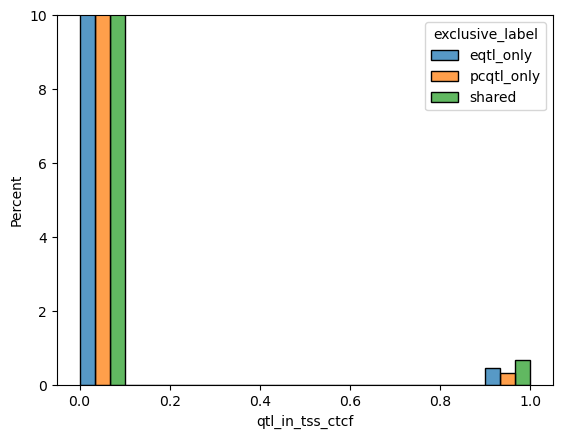

In [227]:
# ctcf peak between the tss
qtls_cluster_annotated['qtl_in_tss_ctcf'] = qtls_cluster_annotated['between_tss'] & qtls_cluster_annotated['qtl_in_ctcf']
qtls_grouped = qtls_cluster_annotated.groupby(['variant_id', 'tissue_id_cluster', 'cluster_id']).agg({'phenotype_id':list, 'qtl_in_tss_ctcf':'sum', 'exclusive_label':'first'})
qtls_grouped['qtl_in_tss_ctcf'] = qtls_grouped['qtl_in_tss_ctcf'] > 0
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qtl_in_tss_ctcf', stat='percent', common_norm=False, bins=10, multiple='dodge')
ax.set_ylim(0, 10)

(0.0, 10.0)

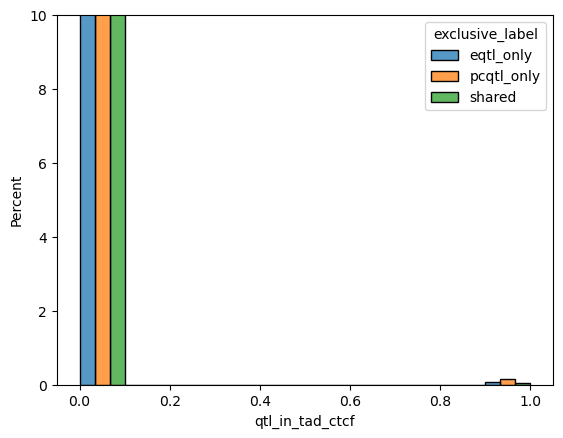

In [228]:
# ctcf peak in a tad
qtls_cluster_annotated['qtl_in_tad_ctcf'] = qtls_cluster_annotated['qtl_in_tad'] & qtls_cluster_annotated['qtl_in_ctcf']
qtls_grouped = qtls_cluster_annotated.groupby(['variant_id', 'tissue_id_cluster', 'cluster_id']).agg({'phenotype_id':list, 'qtl_in_tad_ctcf':'sum', 'exclusive_label':'first'})
qtls_grouped['qtl_in_tad_ctcf'] = qtls_grouped['qtl_in_tad_ctcf'] > 0
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qtl_in_tad_ctcf', stat='percent', common_norm=False, bins=10, multiple='dodge')
ax.set_ylim(0, 10)

In [259]:
# try correctiong on distance
# distance to whichever gene in the cluster is closest
def get_tss(row):
    cluster_gene_df = gid_gencode.loc[row['cluster_id'].split('_')]
    starts = cluster_gene_df['tss_start'].values
    distances = row['position'] - starts
    # return smallest absolute value distance
    idx = np.argmin(abs(distances))
    # make relative to gene orientation
    if cluster_gene_df.iloc[idx]['strand'] == '-':
        return -distances[idx]
    else:
        return distances[idx]
    
qtls_cluster_annotated['cluster_min_distance'] = qtls_cluster_annotated.progress_apply(get_tss, axis=1)
qtls_cluster_annotated['log_qtl_distance'] = np.log10(qtls_cluster_annotated['cluster_min_distance'].abs() +1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34901/34901 [00:28<00:00, 1237.73it/s]
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='log_qtl_distance', ylabel='Percent'>

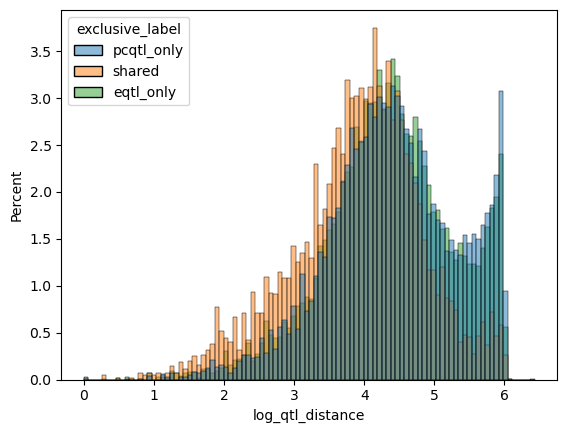

In [260]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='log_qtl_distance', stat='percent', common_norm=False, bins=100)

### make a log odds plot for this

In [229]:
import statsmodels.api as sm

In [230]:
# fit a logit model

def fit_logistic_model(joined_df, column, label_col, correct_on=False, filter_on_column=None, verb=True, correct_on_column='log_size'):
    if verb:
        print(column)
    try:
        final_joined_df = joined_df[joined_df[filter_on_column]]
    except KeyError:
        final_joined_df = joined_df

    if correct_on:
        x = final_joined_df[np.append(np.asarray(correct_on_column),column)].astype(float)
    else:
        x = final_joined_df[column].astype(float)

    y = final_joined_df.reset_index()[label_col].values.astype(bool)
    x_with_constant = sm.add_constant(x) # Add intercept term

    logit_model = sm.Logit(y, x_with_constant)
    try:
        result = logit_model.fit()
        
    except np.linalg.LinAlgError:
        # this can happen if all elements are the same
        return pd.Series({'lower_cb':np.nan, 'upper_cb':np.nan, 'odds_ratio':np.nan, 'p_value':np.nan, 'col':column,'lower_cb_diff':np.nan , 'upper_cb_diff':np.nan}, name=column)
        print(joined_df.head())
        print(column)
        sns.histplot(joined_df[column])
        raise np.linalg.LinAlgError
    if verb:
        print(result.summary())

    coefficients = result.params
    conf_int = result.conf_int()
    odds_ratios = np.exp(coefficients)
    odds_ratios_ci = np.exp(conf_int)

    odds_ratios_ci.rename(columns={0:'lower_cb', 1:'upper_cb'}, inplace=True)
    odds_ratios_ci['odds_ratio'] = odds_ratios
    odds_ratios_ci['p_value'] = result.pvalues
    odds_ratios_ci['col'] = column
    odds_ratios_ci['lower_cb_diff'] = odds_ratios_ci['odds_ratio'] - odds_ratios_ci['lower_cb']
    odds_ratios_ci['upper_cb_diff'] = odds_ratios_ci['upper_cb'] - odds_ratios_ci['odds_ratio']
    
    return odds_ratios_ci.loc[column]


def get_odds_df(joined_df, label_col='pcqtl_bool', verb=True, correct_on=False, correct_on_column='log_size', column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any','has_shared_enhancer',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted', 'has_tads_tss'], 
       filter_list=['max_jaccard_unweighted', 'max_jaccard_weighted', 'num_shared_strong_enhancers', 'num_shared_enhancers', 'has_shared_enhancer', 'qtl_matched_abc_genes', 'qtl_matched_abc_all_genes',  'qtl_num_abc_enhancers', 'qtl_num_abc_all_enhancers'], 
       filter_on_column = 'has_multiple_abc_genes'):
       column_list = pd.Series(column_list)
       odds_ratios_no_filter = pd.DataFrame([fit_logistic_model(joined_df, c, label_col, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[~column_list.isin(filter_list)]]) 
       odds_ratios_filtered = pd.DataFrame([fit_logistic_model(joined_df, c, label_col, filter_on_column=filter_on_column, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[column_list.isin(filter_list)]]) 
       return pd.concat([odds_ratios_no_filter, odds_ratios_filtered])

def make_log_odds_plot(log_odds_df, ax=None):
    log_odds_df = log_odds_df.reset_index()
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    # log odds plot
    ax.errorbar(y=log_odds_df['col'], x=log_odds_df['odds_ratio'], xerr=log_odds_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", color='k')
    ax.axvline(1, color='k', linestyle='--')
    ax.set_xlabel('Log odds')

    for idx,row in log_odds_df.iterrows():
        ax.annotate('OR: {:.2f},\np: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2))
        #axes[0].annotate('log odds={:.1f}'.format(np.log(row['odds_ratio'])), (row['odds_ratio'], idx-.3))
    ax.set_xscale(u'log')
    return ax

# log odds plot with multiple odds per category 
def make_log_odds_plot_multiple(odds_ratios_list, ax=None, labels=None, add_annotations=True, offset = 0.2, colors = sns.color_palette()):
    
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    
    for idx, odds_ratio_df in enumerate(odds_ratios_list):
        odds_ratio_df = odds_ratio_df.reindex(odds_ratios_list[0].index).reset_index()
        color = colors[idx % len(colors)]  # cycle through colors if more than available
        ax.errorbar(y=odds_ratio_df.reset_index().index.values + idx*offset, x=odds_ratio_df['odds_ratio'], 
                    xerr=odds_ratio_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", 
                    color=color, label=labels[idx] if labels else None, markersize=3)
        ax.axvline(1, color='k', linestyle='--')

        if add_annotations:
            for row_idx, row in odds_ratio_df.iterrows():
                ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), 
                            (row['odds_ratio'], row_idx + idx*offset + 0.05), fontsize=6)
            
    if labels:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))

    ax.set_xscale(u'log')
    ax.set_yticks(ticks=odds_ratio_df.index.values + (len(odds_ratios_list)-1)*offset/2, labels=(odds_ratio_df['col']))
    return ax

In [231]:
qtls_cluster_annotated['pcqtl_bool'] = qtls_cluster_annotated['type'] == 'pcqtl'
qtls_cluster_annotated['pcqtl_only_bool'] = qtls_cluster_annotated['exclusive_label'] == 'pcqtl_only'
qtls_cluster_annotated['log_size'] = np.log10(qtls_cluster_annotated['cluster_tss_size'])

<AxesSubplot: xlabel='Mean_pos_cor', ylabel='Percent'>

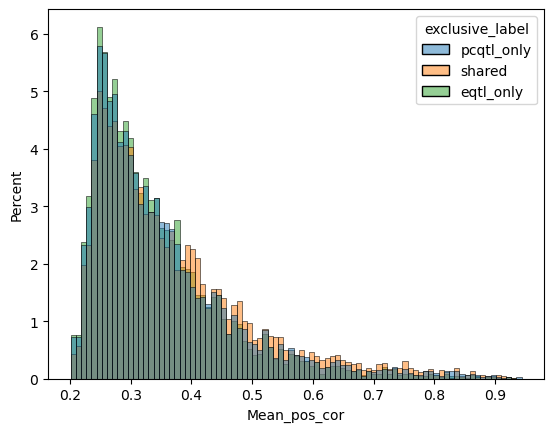

In [232]:
sns.histplot(qtls_cluster_annotated, x='Mean_pos_cor', hue='exclusive_label', common_norm=False, stat='percent')

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.693009
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34901
Model:                          Logit   Df Residuals:                    34899
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:               2.003e-08
Time:                        15:23:28   Log-Likelihood:                -24187.
converged:                       True   LL-Null:                       -24187.
Covariance Type:            nonrobust   LLR p-value:                    0.9752
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0332      0.011 

<AxesSubplot: >

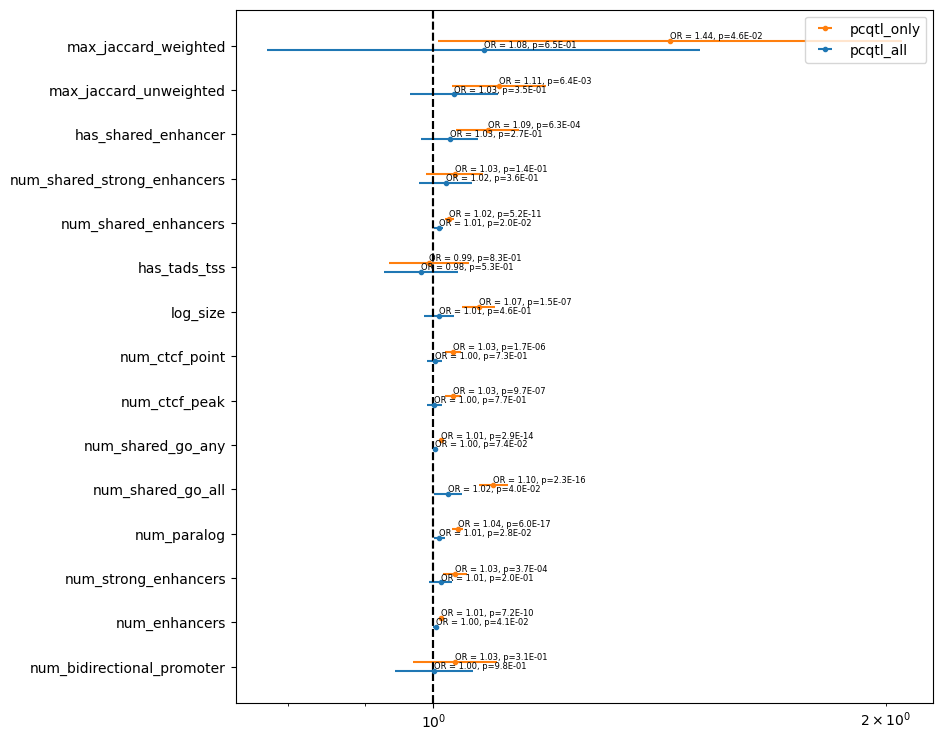

In [233]:
make_log_odds_plot_multiple([get_odds_df(qtls_cluster_annotated, label_col='pcqtl_bool'), 
                             get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool')], labels=['pcqtl_all', 'pcqtl_only'])

median_expression
Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34901
Model:                          Logit   Df Residuals:                    34899
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:               1.092e-05
Time:                        15:23:35   Log-Likelihood:                -24186.
converged:                       True   LL-Null:                       -24187.
Covariance Type:            nonrobust   LLR p-value:                    0.4674
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0317      0.011      2.903      0.004       0.010   

<AxesSubplot: >

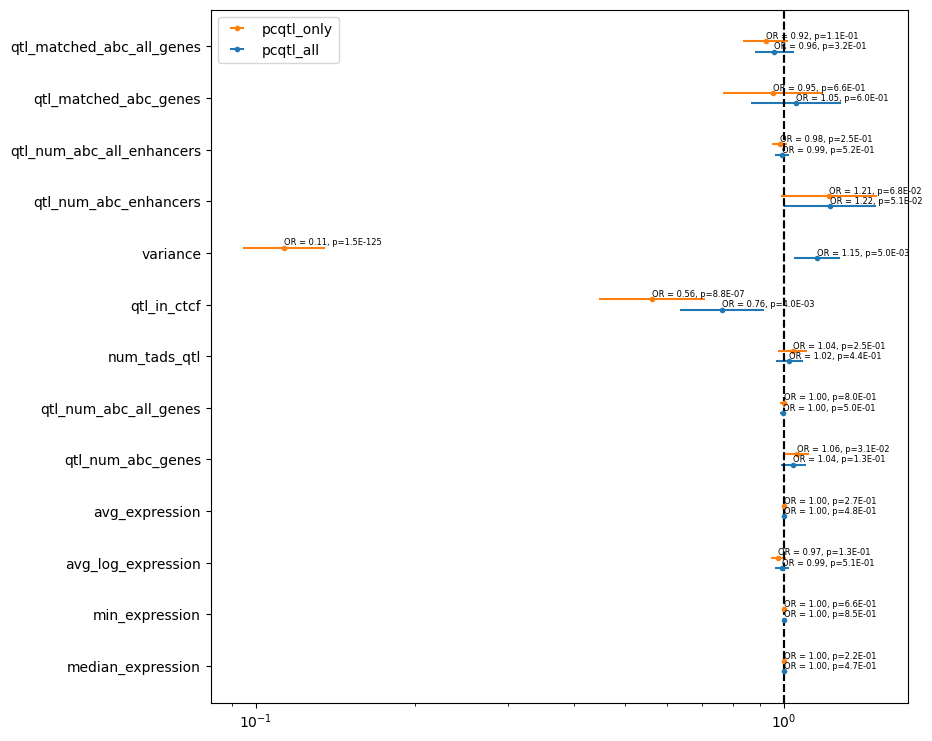

In [234]:
qtl_columns= ['median_expression', 'min_expression', 'avg_log_expression', 'avg_expression', 
              'qtl_num_abc_enhancers', 'qtl_num_abc_all_enhancers', 'qtl_num_abc_genes', 'qtl_num_abc_all_genes', 'qtl_matched_abc_genes', 'qtl_matched_abc_all_genes',
              'num_tads_qtl', 'qtl_in_ctcf', 'variance']


make_log_odds_plot_multiple([get_odds_df(qtls_cluster_annotated, label_col='pcqtl_bool', column_list=qtl_columns), 
                             get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=qtl_columns)], 
                             labels=['pcqtl_all', 'pcqtl_only'])

In [244]:
qtls_cluster_annotated['minor_af'] = np.where(qtls_cluster_annotated['af']>.5, 1-qtls['af'], qtls_cluster_annotated['af'])


log_qtl_distance
Optimization terminated successfully.
         Current function value: 0.692728
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34901
Model:                          Logit   Df Residuals:                    34899
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:               0.0004050
Time:                        16:11:32   Log-Likelihood:                -24177.
converged:                       True   LL-Null:                       -24187.
Covariance Type:            nonrobust   LLR p-value:                 9.595e-06
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1739      0.048     -3.620      0.000      -0.268      -

<AxesSubplot: >

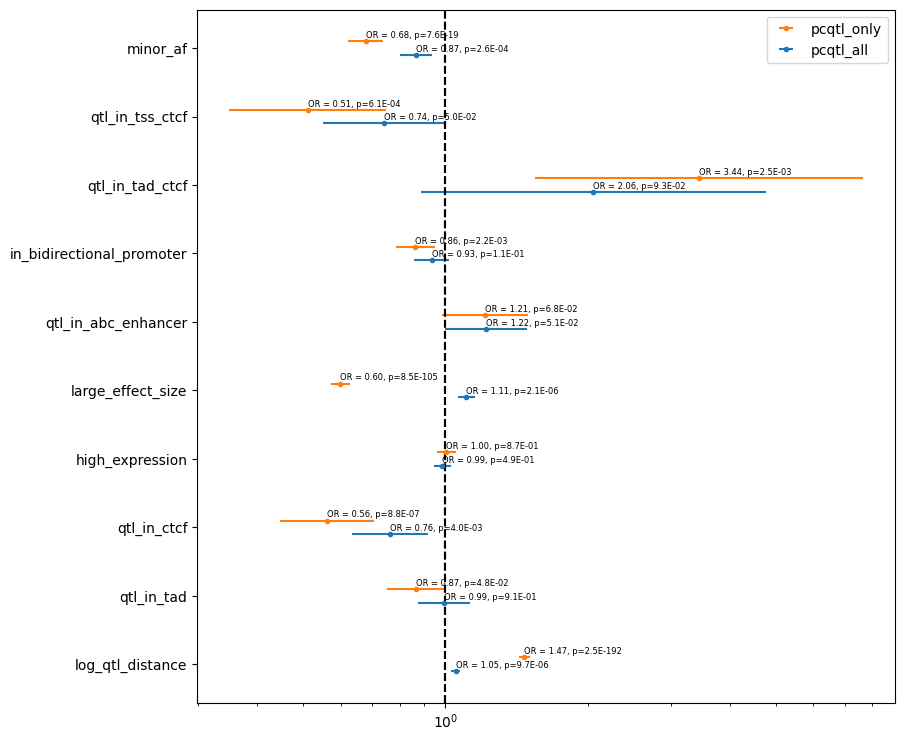

In [268]:
qtls_cluster_annotated['large_effect_size'] = qtls_cluster_annotated['variance'] > qtls_cluster_annotated['variance'].median()
qtls_cluster_annotated['high_expression'] = qtls_cluster_annotated['avg_expression'] > qtls_cluster_annotated['avg_expression'].median()
qtls_cluster_annotated['qtl_in_abc_enhancer'] = qtls_cluster_annotated['qtl_num_abc_enhancers'] > 0

qtl_columns= ['log_qtl_distance', 'qtl_in_tad', 'qtl_in_ctcf', 'high_expression', 'large_effect_size', 'qtl_in_abc_enhancer', 'in_bidirectional_promoter', 'qtl_in_tad_ctcf', 'qtl_in_tss_ctcf', 'minor_af']


make_log_odds_plot_multiple([get_odds_df(qtls_cluster_annotated, label_col='pcqtl_bool', column_list=qtl_columns), 
                             get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=qtl_columns)], 
                             labels=['pcqtl_all', 'pcqtl_only'])

qtl_in_tad
Optimization terminated successfully.
         Current function value: 0.612973
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34901
Model:                          Logit   Df Residuals:                    34898
Method:                           MLE   Df Model:                            2
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:                0.001949
Time:                        16:12:27   Log-Likelihood:                -21393.
converged:                       True   LL-Null:                       -21435.
Covariance Type:            nonrobust   LLR p-value:                 7.119e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7001      0.018    -38.497      0.000      -0.736      -0.664
minor_af      -0.3

<AxesSubplot: >

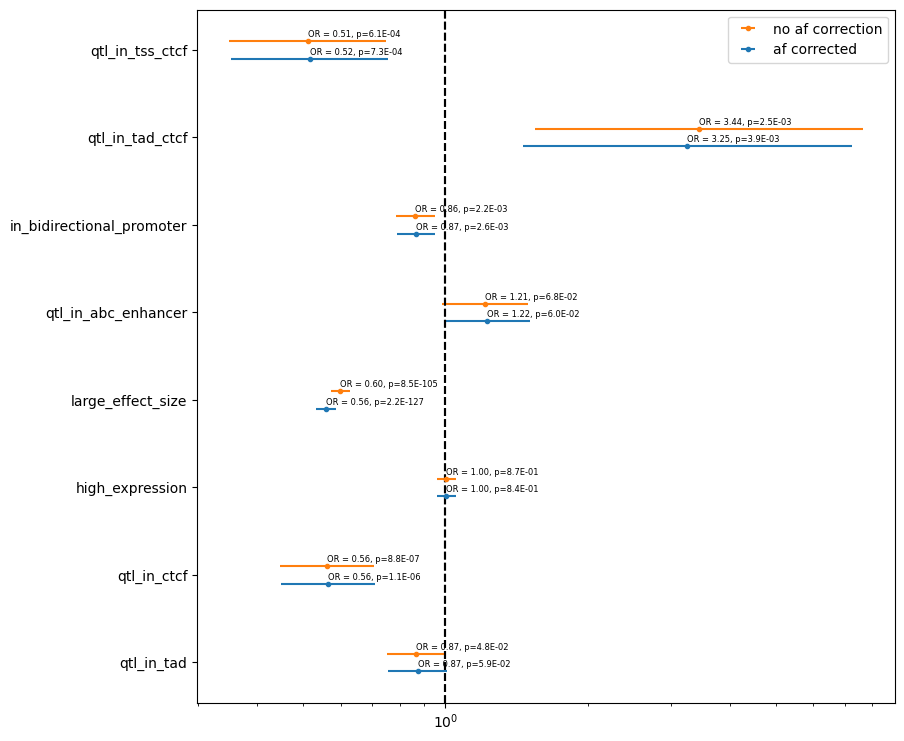

In [270]:
qtls_cluster_annotated['large_effect_size'] = qtls_cluster_annotated['variance'] > qtls_cluster_annotated['variance'].median()
qtls_cluster_annotated['high_expression'] = qtls_cluster_annotated['avg_expression'] > qtls_cluster_annotated['avg_expression'].median()
qtls_cluster_annotated['qtl_in_abc_enhancer'] = qtls_cluster_annotated['qtl_num_abc_enhancers'] > 0

qtl_columns= ['qtl_in_tad', 'qtl_in_ctcf', 'high_expression', 'large_effect_size', 'qtl_in_abc_enhancer', 'in_bidirectional_promoter', 'qtl_in_tad_ctcf', 'qtl_in_tss_ctcf']


make_log_odds_plot_multiple([get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=qtl_columns, correct_on_column='minor_af', correct_on=True), 
                             get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=qtl_columns)], 
                             labels=['af corrected', 'no af correction'])

In [68]:
qtls_cluster_annotated['first_pc_bool'] = (qtls_cluster_annotated['pc_order'] == 'first') & (qtls_cluster_annotated['exclusive_label']=='pcqtl_only')
qtls_cluster_annotated['middle_pc_bool'] = (qtls_cluster_annotated['pc_order'] == 'middle')  & (qtls_cluster_annotated['exclusive_label']=='pcqtl_only')
qtls_cluster_annotated['last_pc_bool'] = (qtls_cluster_annotated['pc_order'] == 'last' ) & (qtls_cluster_annotated['exclusive_label']=='pcqtl_only')

median_expression
Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34901
Model:                          Logit   Df Residuals:                    34899
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:               1.092e-05
Time:                        12:58:48   Log-Likelihood:                -24186.
converged:                       True   LL-Null:                       -24187.
Covariance Type:            nonrobust   LLR p-value:                    0.4674
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0317      0.011      2.903      0.004       0.010   

<AxesSubplot: >

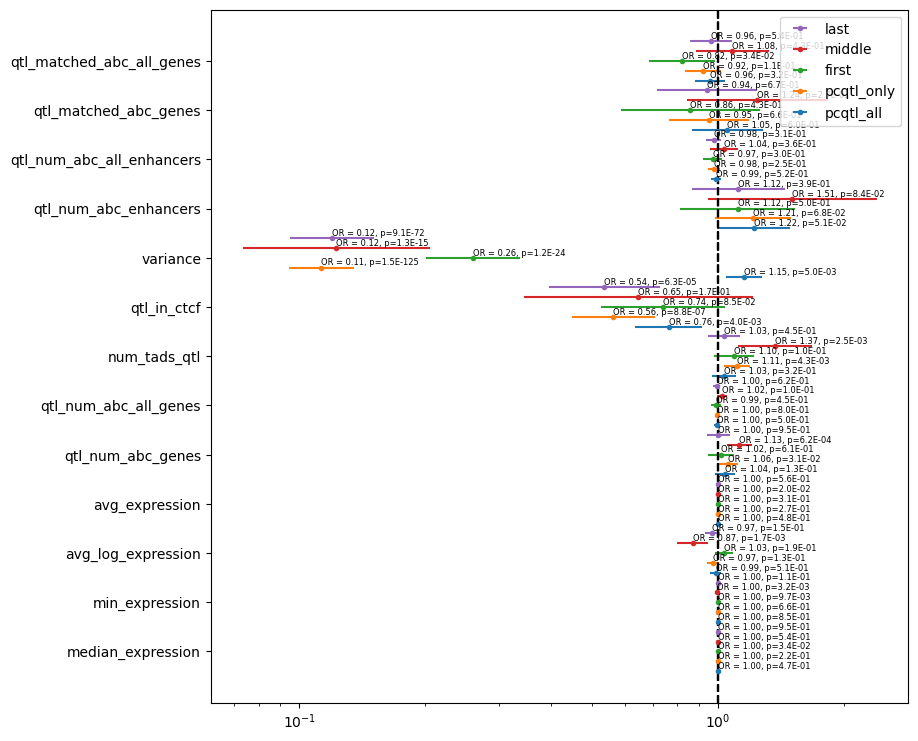

In [77]:
qtl_columns= ['median_expression', 'min_expression', 'avg_log_expression', 'avg_expression', 
              'qtl_num_abc_enhancers', 'qtl_num_abc_all_enhancers', 'qtl_num_abc_genes', 'qtl_num_abc_all_genes', 'qtl_matched_abc_genes', 'qtl_matched_abc_all_genes',
              'num_tads_qtl', 'qtl_in_ctcf', 'variance']
make_log_odds_plot_multiple([get_odds_df(qtls_cluster_annotated, label_col='pcqtl_bool', column_list=qtl_columns), 
                             get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=qtl_columns),
                             get_odds_df(qtls_cluster_annotated, label_col='first_pc_bool', column_list=qtl_columns),
                             get_odds_df(qtls_cluster_annotated, label_col='middle_pc_bool', column_list=qtl_columns),
                             get_odds_df(qtls_cluster_annotated, label_col='last_pc_bool', column_list=qtl_columns)], 
                             labels=['pcqtl_all', 'pcqtl_only', 'first', 'middle', 'last'])

qtl_num_abc_genes_bool
Optimization terminated successfully.
         Current function value: 0.692954
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34901
Model:                          Logit   Df Residuals:                    34899
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:               7.892e-05
Time:                        13:06:46   Log-Likelihood:                -24185.
converged:                       True   LL-Null:                       -24187.
Covariance Type:            nonrobust   LLR p-value:                   0.05072
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0311      0.011      2.885      

<AxesSubplot: >

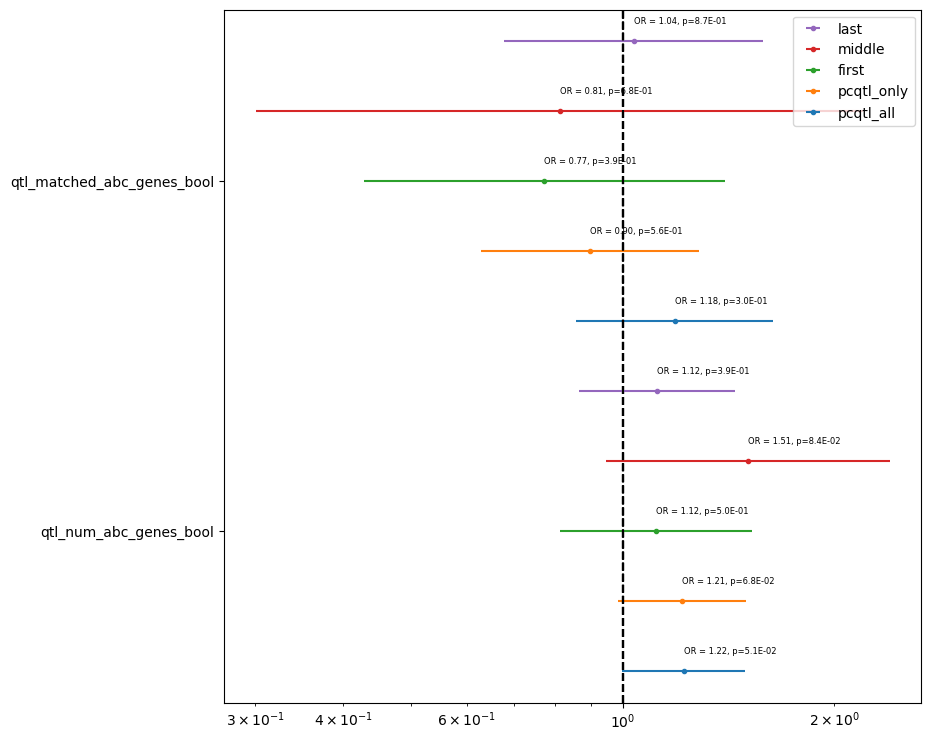

In [91]:
# make them binary columns
qtls_cluster_annotated['has_multiple_abc_genes'] = qtls_cluster_annotated['qtl_num_abc_enhancers']> 0
qtls_cluster_annotated['qtl_num_abc_genes_bool']  = qtls_cluster_annotated['qtl_num_abc_genes']> 0
qtls_cluster_annotated['qtl_matched_abc_genes_bool']  = qtls_cluster_annotated['qtl_matched_abc_genes']> 0


qtl_columns= ['qtl_num_abc_genes_bool', 'qtl_matched_abc_genes_bool']
make_log_odds_plot_multiple([get_odds_df(qtls_cluster_annotated, label_col='pcqtl_bool', column_list=qtl_columns), 
                             get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=qtl_columns),
                             get_odds_df(qtls_cluster_annotated, label_col='first_pc_bool', column_list=qtl_columns),
                             get_odds_df(qtls_cluster_annotated, label_col='middle_pc_bool', column_list=qtl_columns),
                             get_odds_df(qtls_cluster_annotated, label_col='last_pc_bool', column_list=qtl_columns)], 
                             labels=['pcqtl_all', 'pcqtl_only', 'first', 'middle', 'last'])

in_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.614034
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                34901
Model:                          Logit   Df Residuals:                    34899
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:               0.0002223
Time:                        15:47:27   Log-Likelihood:                -21430.
converged:                       True   LL-Null:                       -21435.
Covariance Type:            nonrobust   LLR p-value:                  0.002022
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.8191      0.012    -

<AxesSubplot: >

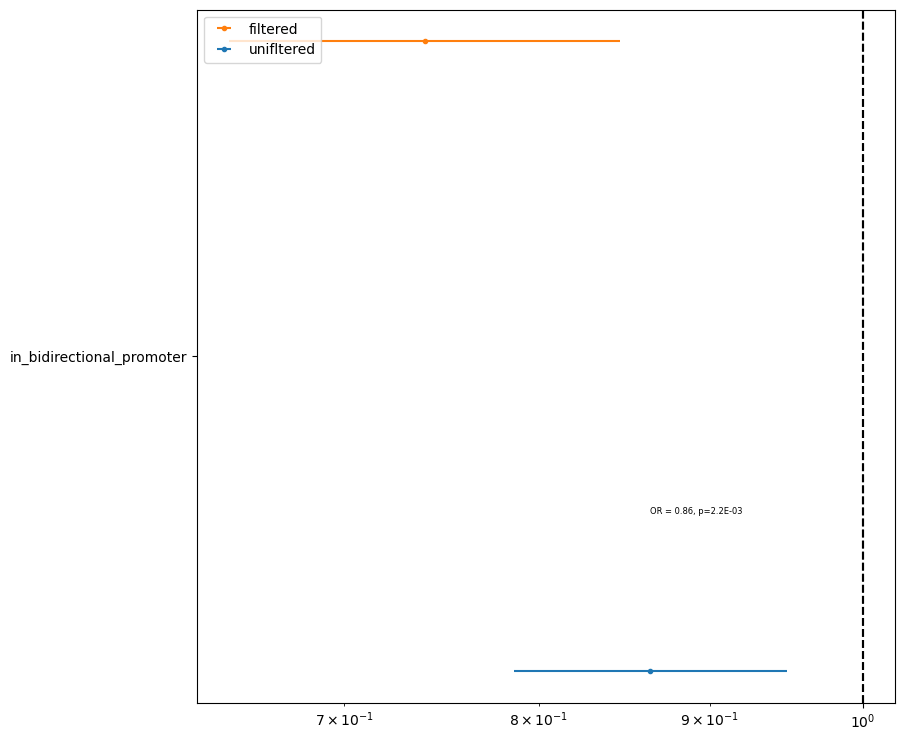

In [242]:
make_log_odds_plot_multiple([get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=['in_bidirectional_promoter']), 
                             get_odds_df(qtls_cluster_annotated, label_col='pcqtl_only_bool', column_list=['in_bidirectional_promoter'], filter_list=['in_bidirectional_promoter'], filter_on_column='has_bidirectional_promoter')], 
                             labels=['unifltered', 'filtered'])

In [ ]:
get_odds_df(qtls_cluster_annotated[qtls_cluster_annotated['Mean_neg_cor'].isna()], label_col='pcqtl_only_bool', column_list='in_bidirectional_promoter', filter_list=['in_bidirectional_promoter'], filter_on_column='has_bidirectional_promoter')